# Bike Share Raw Data

In London, UK and Taipei, Taiwan, there are bike-share systems using docks. A rental event is recorded at least as a start station, an end station, and the two corresponding times. This defines a spatiotemporal data set, or in other words, a multi-dimensional time-series on a graph.

The raw data files have been retrieved from the respective bike-sharing system operators, parsed and moderately reformatted (e.g. making column names uniform over all data), then saved into one CSV file per city, rows sorted on start date. Only raw data from 2017 and up until mid-2020 are included.

The raw data sources are:
* https://cycling.data.tfl.gov.uk
* https://data.taipei/#/dataset?topic=topic-transportation

For examples of analyses of this data as blog posts, follow these links:

* Build usage baseline and contrast how COVID-19 impact usage when and where: https://towardsdatascience.com/responses-to-covid-19-in-taipei-and-london-as-revealed-by-bike-sharing-5fcb215f2341
* Simple graph convolutional neural networks for forecasting rental events: https://towardsdatascience.com/london-bike-ride-forecasting-with-graph-convolutional-networks-aee044e48131
* Descriptive analysis and visualization for London data: https://medium.com/@AJOhrn/data-footprint-of-bike-sharing-in-london-be9e11425248

Academic article using the same type of data:
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9093851

Next I provide a handful of helpful commands to enable analysis.

## Load Data and Basic Cleaning and Extension

In [22]:
import pandas as pd
import numpy as np

Start with London, and load all bike-share data for the Santander London system, January 2017 up until mid-2020. Parse the two time columns as datetime types.

In [23]:
df_london = pd.read_csv('london.csv', parse_dates=[3,6], infer_datetime_format=True)
df_london.shape

(38215560, 9)

The data includes rare rental events that are started but not ended. For some analysis these are best removed.

In [24]:
df_london = df_london.loc[~df_london.isnull().any(axis=1)]
df_london = df_london.astype({'bike_id' : 'int32', 'end_station_id' : 'int32', 'start_station_id' : 'int32'})
df_london.shape

(38147278, 9)

Augment datetime data to make it easier for binning and applying conditions with respect to time.

In [25]:
df_london.loc[:, 'year'] = df_london['start_rental_date_time'].dt.year
df_london.loc[:, 'month'] = df_london['start_rental_date_time'].dt.month
df_london.loc[:, 'week'] = df_london['start_rental_date_time'].dt.week
df_london.loc[:, 'day'] = df_london['start_rental_date_time'].dt.day
df_london.loc[:, 'hour'] = df_london['start_rental_date_time'].dt.hour
df_london.loc[:, 'dayofweek'] = df_london['start_rental_date_time'].dt.dayofweek
df_london.loc[:, 'satsun'] = df_london['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_london.shape

(38147278, 16)

A handful of stations are very rarely part of any rental events. In some cases these are temporary stations or stations that become decommissioned. In some analysis these low count stations are best removed.

In [26]:
below_or_above_stations = df_london['start_station_name'].value_counts() < 500
low_stations = below_or_above_stations.loc[below_or_above_stations].index
df_london = df_london.loc[~df_london['start_station_name'].isin(low_stations)]
df_london = df_london.loc[~df_london['end_station_name'].isin(low_stations)]
df_london.shape

(38144414, 16)

## Analysis Can Begin (London)

On this dataset descriptive analysis can be made. Examples of that include seasonal effects, weekday verus weekend, particular stations that change the most between years etc. A simple example is the number of rental events in the months of a particular year, say 2018.

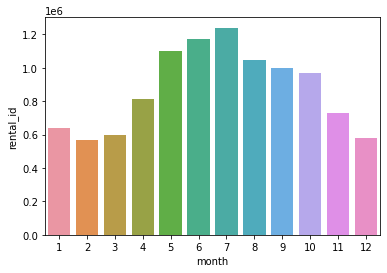

In [27]:
import seaborn as sns
per_month_2018_group = df_london.loc[df_london['year'] == 2018].groupby('month')
month_counts = per_month_2018_group.count()

sns.barplot(x=month_counts.index, y=month_counts.iloc[:,0])

Another example is to analyze time-series for specific stations within a day, like station 14 (a major commuter station in London) during weekdays.

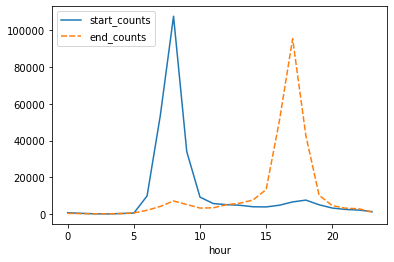

In [28]:
weekday_14_start = df_london.loc[(df_london['start_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_end = df_london.loc[(df_london['end_station_id'] == 14) & (df_london['satsun'] == False)]
weekday_14_start = weekday_14_start.groupby('hour').count()
weekday_14_end = weekday_14_end.groupby('hour').count()
weekday_14_data = pd.DataFrame({'start_counts' : weekday_14_start.iloc[:,0],
                                'end_counts' : weekday_14_end.iloc[:,0]})

sns.lineplot(data=weekday_14_data)

Longitude and latitude data is also available for each station.

In [29]:
df_london_geo = pd.read_csv('london_stations.csv')
df_london_geo.head(5)

,station_id,station_name,longitude,latitude
0,1,"River Street, Clerkenwell",-0.109971,51.5292
1,2,"Phillimore Gardens, Kensington",-0.197574,51.4996
2,3,"Christopher Street, Liverpool Street",-0.084606,51.5213
3,4,"St. Chad's Street, King's Cross",-0.120974,51.5301
4,5,"Sedding Street, Sloane Square",-0.156876,51.4931


Additional analysis and data mining are easy to image, some of which can be found in this blog post:  https://medium.com/@AJOhrn/data-footprint-of-bike-sharing-in-london-be9e11425248

More advanced analysis can use the data to model the distributions of expected rental events at different stations and/or time of day. For example, it has been found that weather matters a great deal to rental events. A Bayesian analysis that models what weather conditions implies for the distribution, can be attempted through cross-referencing this data with weather data for London.

**Note that the data contains a major concept shift in March 2020** when the COVID-19 pandemic impacts London. That itself can be subject of analysis, as shown in this blog post:  https://towardsdatascience.com/responses-to-covid-19-in-taipei-and-london-as-revealed-by-bike-sharing-5fcb215f2341

Have fun!

## Graph Analysis

The data can be subject to graph analysis, with each station a vertex in the graph and the edge weight between two vertices related to the number of rental events involves the corresponding pair of stations. The directed weighted adjacency matrix is the key quantity.

In [152]:
station_pair_group = df_london.groupby(['start_station_name', 'end_station_name'])
station_pair_count = station_pair_group.count().iloc[:,0]

There are multiple valid relations between edge weight and number of rental events involving the corresponding pair of stations. One is to relate the weight to the percentage of all rental events from the given start station that flows through the given edge.

In [153]:
total_by_start_station = station_pair_count.groupby('start_station_name').sum()
rel_weight = 100.0 * station_pair_count.div(total_by_start_station, level=0)

Rare connections can sometimes be removed in order to make the graph representation sparser.

In [154]:
rel_weight = rel_weight.loc[rel_weight > 1.0]

In some analysis (and especially visualizations) the adjacency matrix needs to account for no adjacency. The `rel_weight` data frame accounts for non-zero adjacencies. The full matrix is thus constructed by adding zeros.

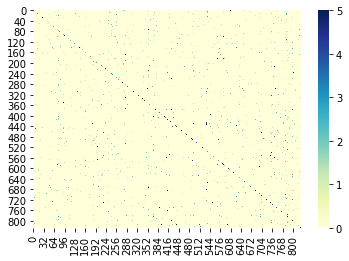

In [159]:
import numpy as np
stations = np.union1d(df_london['start_station_name'].unique(), df_london['end_station_name'].unique())
mindex_square = pd.MultiIndex.from_product([stations, stations])
rel_weight_square = rel_weight.reindex(index=mindex_square, fill_value=0.0)
rel_weight_square = rel_weight_square.unstack()
sns.heatmap(rel_weight_square.values, vmin=0.0, vmax=5.0, cmap="YlGnBu")

Some network analysis can be done by representing the directed weighted graph as a `DiGraph` instance from the `networkx` library.

In [148]:
import networkx as nx
dg = nx.DiGraph()
dg.add_nodes_from(stations)

The edge definitions require edges to be defined as a three-membered tuple.

In [149]:
edge_weights_dict = rel_weight.to_dict()
edge_weights_data = [(key1, key2, val) for (key1, key2), val in edge_weights_dict.items()]
dg.add_weighted_edges_from(edge_weights_data)

A range of analysis can be run using methods in `networkx.algorithms`. One example is the node clusterings.

In [162]:
node_clusterings = nx.algorithms.cluster.clustering(dg)
sorted(node_clusterings.items(), key=lambda kv: kv[1])

[('Allington Street, Victoria', 0),
 ('Clarges Street, Mayfair', 0),
 ('Frith Street, Soho', 0),
 ('Grafton Street, Mayfair', 0),
 ('Mechanical Workshop Clapham', 0),
 ('Melton Street, Euston', 0.02197802197802198),
 ("St. James's Square, St. James's", 0.027105517909002903),
 ('Farringdon Street, Holborn', 0.02727272727272727),
 ("Belgrove Street , King's Cross", 0.02936640534635651),
 ('Kings Gate House, Westminster', 0.03636363636363636),
 ('Craven Street, Strand', 0.03777777777777778),
 ('St. George Street, Mayfair', 0.03787878787878788),
 ('Waterloo Station 3, Waterloo', 0.03810429313245082),
 ('Kingsway Southbound, Strand', 0.0392156862745098),
 ('Bruton Street, Mayfair', 0.041666666666666664),
 ('Waterloo Station 1, Waterloo', 0.047047265582360005),
 ('William IV Street, Strand', 0.049019607843137254),
 ('Farm Street, Mayfair', 0.05),
 ("St Mary's Hospital, Westminster", 0.051666666666666666),
 ('South Wharf Road, Paddington', 0.05198019801980198),
 ('Endsleigh Gardens, Euston', 

## Graph Convolution Networks

A continuation of the graph analysis is to employ Graph Convolution Networks (GCNs) to model the rental time-series. One possible application is in forecasting, taking into account the known spatial relations between the stations, as illustrated in this blog post: https://towardsdatascience.com/london-bike-ride-forecasting-with-graph-convolutional-networks-aee044e48131 Other applications can be classification of stations on basis of its "when-and-where" place in the bike-sharing system. Possible options are in no shortage... useful options is another question.

One possibility is to use the [PyTorch Geometric library](https://pytorch-geometric.readthedocs.io/en/latest/index.html). The graph of the bike system has then to be represented as required by PyTorch Geometric. The edge data is represented in the 

In [196]:
import torch
from torch_geometric.data import Data

I create dummy node input features, which typically are replaced with an *input feature* to the neural network. I also create dummy node output features. Other types of output can be imaged, like a system-wide feature (weather, day of week, how many are home sick with the flu etc etc etc).

In [221]:
stations_dummy_inp_features = torch.tensor([np.random.ranf() for s in stations])
stations_dummy_out_features = torch.tensor([np.random.ranf() for s in stations])

The adjacency matrix is represented in the COO format, and the weights are made into edge attributes. For those GCN methods that use weights, that is what PyTorch Geometric expects.

In [222]:
edge_s = []
edge_t = []
edge_attr = []
for row, value in rel_weight.items():
    edge_s.append(list(stations).index(row[0]))
    edge_t.append(list(stations).index(row[1]))
    edge_attr.append(value)
    
edge_index = torch.tensor([edge_s, edge_t])
edge_attr = torch.tensor(edge_attr).unsqueeze(1)

Put it all together.

In [223]:
pyg_graphtensor = Data(x=stations_dummy_inp_features, y=stations_dummy_out_features,
                       edge_index=edge_index, edge_attr=edge_attr)

The neural network model has to be built after this, along with a dataset comprised of several instances of `Data`. These are details for another notebook.

## Analysis Continues (Taipei)

The data for Taipei bike-sharing system can undergo the same analysis as outlined above for London. The data for Taipei is slightly different, however. I will highlight these differences only.

In [9]:
df_taipei = pd.read_csv('taipei.csv', parse_dates=[0,2,5], infer_datetime_format=False)
df_taipei.shape

(83239274, 8)

In [15]:
df_taipei.loc[:, 'year'] = df_taipei['start_rental_date_hour'].dt.year
df_taipei.loc[:, 'month'] = df_taipei['start_rental_date_hour'].dt.month
df_taipei.loc[:, 'week'] = df_taipei['start_rental_date_hour'].dt.week
df_taipei.loc[:, 'day'] = df_taipei['start_rental_date_hour'].dt.day
df_taipei.loc[:, 'hour'] = df_taipei['start_rental_date_hour'].dt.hour
df_taipei.loc[:, 'dayofweek'] = df_taipei['start_rental_date_hour'].dt.dayofweek
df_taipei.loc[:, 'satsun'] = df_taipei['dayofweek'].map({0: False, 1: False, 2: False, 3: False, 4: False, 5: True, 6:True})
df_taipei.shape

(83239274, 15)

In [17]:
df_taipei.head(8)

,start_rental_date_hour,start_station_name_tradchinese,end_rental_date_hour,end_station_name_tradchinese,duration,start_date,start_station_name_pinyin,end_station_name_pinyin,year,month,week,day,hour,dayofweek,satsun
0,2017-01-01,捷運善導寺站(1號出口),2017-01-01 00:00:00,捷運江子翠站(3號出口),2847.0,2017-01-01,jieyunshandaosizhan(1haochukou),jieyunjiangzicuizhan(3haochukou),2017,1,52,1,0,6,True
1,2017-01-01,松山車站,2017-01-01 01:00:00,捷運昆陽站(1號出口),548.0,2017-01-01,songshanchezhan,jieyunkunyangzhan(1haochukou),2017,1,52,1,0,6,True
2,2017-01-01,捷運劍南路站(2號出口),2017-01-01 00:00:00,捷運港墘站(2號出口),1832.0,2017-01-01,jieyunjiannanluzhan(2haochukou),jieyungangqizhan(2haochukou),2017,1,52,1,0,6,True
3,2017-01-01,捷運港墘站(2號出口),2017-01-01 01:00:00,捷運東湖站,2404.0,2017-01-01,jieyungangqizhan(2haochukou),jieyundonghuzhan,2017,1,52,1,0,6,True
4,2017-01-01,關渡宮,2017-01-01 00:00:00,捷運竹圍站,678.0,2017-01-01,guandugong,jieyunzhuweizhan,2017,1,52,1,0,6,True
5,2017-01-01,捷運小巨蛋站(5號出口),2017-01-01 01:00:00,興安華城,924.0,2017-01-01,jieyunxiaojudanzhan(5haochukou),xinganhuacheng,2017,1,52,1,0,6,True
6,2017-01-01,林口公園,2017-01-01 00:00:00,玉成公園,814.0,2017-01-01,linkougongyuan,yuchenggongyuan,2017,1,52,1,0,6,True
7,2017-01-01,捷運港墘站(2號出口),2017-01-01 01:00:00,捷運東湖站,1717.0,2017-01-01,jieyungangqizhan(2haochukou),jieyundonghuzhan,2017,1,52,1,0,6,True


Contrasts with London dataset:
* Taipei bike-sharing is larger than London (a bit over double the number of rental events).  
* The stations are not assigned a numeric ID by the operator. As part of the analysis that can be added.
* The station names are in traditional chinese. In order to enable easy filtering for users who cannot easily read or write such characters, the `pinyin` library has been used to create basic Pinyin Romanizations of the station names. 
* The times for start and end of rental is only resolved up to the hour (hence the suffix `_hour` rather than `time`). Note that duration of the bike rental is in units of seconds, however.

Otherwise the data tracks the same transport activity as the data set for London. Comparison between the two cities can therefore be done. In a previous study it has been found that the rental events distribute quite distinctly over time of day for the two cities, see the discussion about MDS and Jensen-Shannon in this blog post:  https://towardsdatascience.com/responses-to-covid-19-in-taipei-and-london-as-revealed-by-bike-sharing-5fcb215f2341

Good luck